In [2]:
# ensure classes imported from .py files are dynamically updated
%load_ext autoreload
%autoreload 2

# plot matplots nicely
%matplotlib inline  

In [3]:
# import from pythin packages
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import cmocean

# import from pre-built data classes
from data_handler import *
from plotting_fns import PlottingFns as pfns
from region import Region as rg
from utils import Color as uc

pfns = pfns()

In [4]:
# get hi res GEBCO
gebco_coarse = GEBCO(coarsen_factor=40).ds
gebco_fine = GEBCO(coarsen_factor=10).ds

In [5]:
profiles = GPHA().profile_df
profiles = profiles.astype({'float_id':str})
profiles_argo = profiles[profiles.float_type=='ARGO']
profiles_meop = profiles[profiles.float_type=='MEOP']

In [6]:
def plot_profiles_for_region(region, hires=False, markersize=1.6, markerstyle='.', figsize=(14,8)):
    
    print('Cropping gebco..')
    gebco_region = region.crop_da(gebco_fine if hires else gebco_coarse,ignore_elevation=True)

    print('Cropping profile dataframes..')
    argo_crop = region.crop_df(profiles_argo)
    meop_crop = region.crop_df(profiles_meop)
    
    print('Found MEOP profiles with float IDS: ')
    print(meop_crop.float_id.unique())
    print('Found ARGO profiles with float IDS: ')
    print(argo_crop.float_id.unique())
    
    print('Plotting bathymetry..')
    fig,ax = plt.subplots(figsize=figsize,subplot_kw={'projection': ccrs.SouthPolarStereo()})
    pfns.sp(ax,gebco_region.elevation,vmin=-5000,vmax=0,cmap=cmocean.cm.deep_r,cbar="Elevation (m)",cbar_orientation='vertical',extent=region.extent)
    
    print('Plotting profile locations.. (markerstyle={})'.format(markerstyle))
    ax.plot(meop_crop.lon,meop_crop.lat,markerstyle,ms=markersize,transform=ccrs.PlateCarree(),color=uc.MEOP.value[0],label='MEOP')
    ax.plot(argo_crop.lon,argo_crop.lat,markerstyle,ms=markersize,transform=ccrs.PlateCarree(),color=uc.ARGO.value[0],label='ARGO')
    ax.legend(loc='upper left')
      
    print('Manifesting')
    ids = [meop_crop.float_id.unique(),  argo_crop.float_id.unique()]
    return ids

In [7]:
# ross_region=rg('Ross Sea',[150,-160,-79,-70],elevation=gebco_fine.elevation,min_elevation=-1000)
# ids=plot_profiles_for_region(ross_region)

In [40]:
def plot_float(float_id,ax):
    fps = profiles[profiles.float_id==float_id]
    #fps = fps[fps.gph != 0]
        
    latmax = fps.lat.max()
    latmin = fps.lat.min()
    
    crosses180 = any(fps.lon>0) & any(fps.lon<0)
    lonmax = (fps.lon[fps.lon < 0]).max() if crosses180 else fps.lon.max()
    lonmin = (fps.lon[fps.lon > 0]).min() if crosses180 else fps.lon.min()
    
    fr = rg('Float ' + float_id + ' Area',[lonmin,lonmax,latmin,latmax],elevation=gebco_fine.elevation)
    fr_extended = rg('Float ' + float_id + ' Area',[-180,-160,-80,-75],elevation=gebco_fine.elevation)

    
    #fig,ax = plt.subplots(1,2,figsize=(18,6),subplot_kw={'projection': ccrs.SouthPolarStereo()})
    fr.plot_region(sea='Ross Sea',ax=ax[0])
    
    gebco_region = fr_extended.crop_da(gebco_fine,ignore_elevation=True)

    pfns.sp(ax[1],gebco_region.elevation,vmin=-5000,vmax=0,cmap=cmocean.cm.deep_r,extent=fr.extent)
    
    im = ax[1].scatter(fps.lon,fps.lat,c=fps.index,cmap=cmocean.cm.amp,transform=ccrs.PlateCarree())
    cbar = plt.colorbar(im)
    cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
    
    return fr

In [42]:
def analyse_float(float_id,axs):
    fps = profiles[profiles.float_id==float_id]
    #fps = fps[fps.gph != 0]
    
    #fig,axs = plt.subplots(1,2,figsize=(16,4),gridspec_kw={'width_ratios': [2,1]})
    im = axs[0].scatter(fps.index,fps.gph,c=fps.index,cmap=cmocean.cm.amp)
    axs[0].grid()
    axs[0].set_ylabel('GPH (m)')
    cbar = plt.colorbar(im,ax=axs[0])
    cbar.ax.set_yticklabels(pd.to_datetime(cbar.get_ticks()).strftime(date_format='%b %Y'))
    
    cmt = fps.groupby(by=fps.index.month).mean()
    axs[1].plot(cmt.index,cmt.gph, color='firebrick', linewidth=2)
    axs[1].set_xticks(np.arange(1,13))
    axs[1].set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    axs[1].set_xlim([0.5,12.5])
    axs[1].grid()


In [36]:
def get_axes():
      fig = plt.figure(figsize=(18,10))

      gs = fig.add_gridspec(2,5)
      axs1=[fig.add_subplot(gs[0, 0:2],projection=ccrs.SouthPolarStereo()),
            fig.add_subplot(gs[0, 2:],projection=ccrs.SouthPolarStereo())]
      axs2=[fig.add_subplot(gs[1, 0:3]),
            fig.add_subplot(gs[1, 3:])]

      return fig,axs1,axs2

Text(0, 0.5, 'GPH (m)')

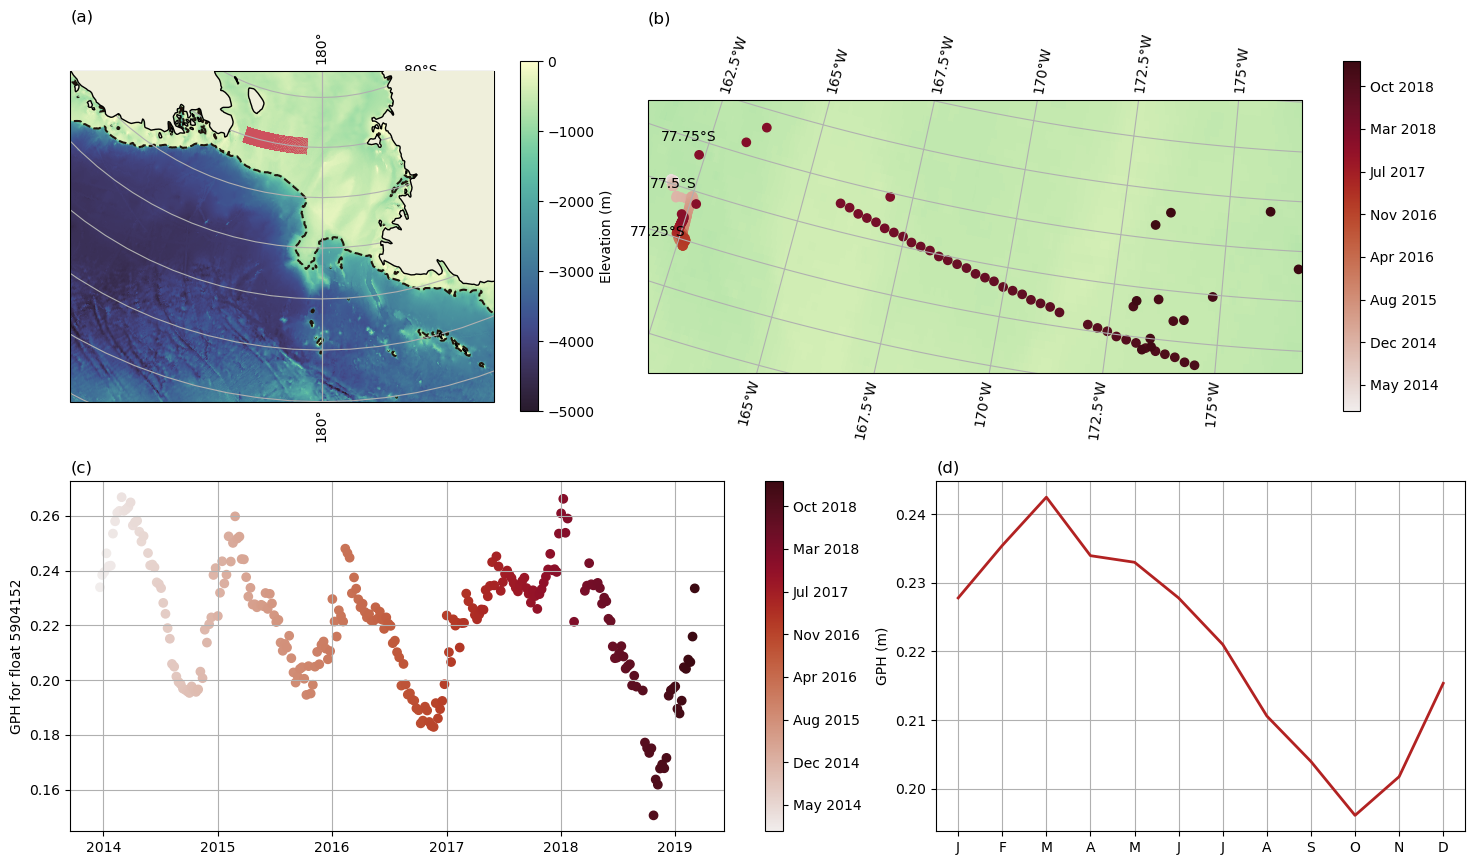

In [41]:
fig,axs1,axs2 = get_axes()
id = '5904152'
plot_float(id,axs1)
analyse_float(id,axs2)
axs1[0].set_title('(a)',loc='left')
axs1[1].set_title('(b)',loc='left')
axs2[0].set_title('(c)',loc='left')
axs2[1].set_title('(d)',loc='left')
axs2[1].set_ylabel('GPH (m)')


In [44]:
fig.savefig('plots/figureS2.png',dpi=200,transparent=False,bbox_inches='tight')